In [6]:
import duckdb
import polars as pl
import pandas as pd

# Load the TSV file
file_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data\prescoringRaterModelOutput_3dim.tsv"

# Using Polars to load and analyze
df = pl.read_csv(file_path, separator='\t')

# Print the range of internalRaterFactor1
min_val = df['internalRaterFactor1'].min()
max_val = df['internalRaterFactor1'].max()

print(f"Range of internalRaterFactor1:")
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")
print(f"Range: {max_val - min_val}")

Range of internalRaterFactor1:
Minimum: -1.5152386
Maximum: 0.83323216
Range: 2.34847076


In [ ]:
# Load the main dataset
parquet_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data\user_period_master_complete.parquet"
main_df = pl.read_parquet(parquet_path)

C:\Users\wongb\AppData\Local\Temp\ipykernel_29220\2527375000.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("user_count")


less_than_neg1: 66520 records, 72 time periods
neg1_to_neg0_5: 2092147 records, 72 time periods
neg1_to_neg0_5: 2092147 records, 72 time periods
neg0_5_to_0: 2957257 records, 72 time periods
neg0_5_to_0: 2957257 records, 72 time periods
0_to_0_5: 792235 records, 72 time periods
more_than_0_5: 11460 records, 72 time periods

Datasets created successfully!
0_to_0_5: 792235 records, 72 time periods
more_than_0_5: 11460 records, 72 time periods

Datasets created successfully!


In [2]:
# Create quintile-based grouping (equal number of participants per group)
import numpy as np

# Filter out null values in internalRaterFactor1 before sorting
df_sorted = df.filter(pl.col("internalRaterFactor1").is_not_null()).sort("internalRaterFactor1")
total_participants = len(df_sorted)
quintile_size = total_participants // 5

print(f"Total participants: {total_participants}")
print(f"Quintile size: {quintile_size}")

# Create quintile groups
quintile_categories = {}
for i in range(5):
    start_idx = i * quintile_size
    if i == 4:  # Last group gets any remainder
        end_idx = total_participants
    else:
        end_idx = (i + 1) * quintile_size
    
    group_df = df_sorted.slice(start_idx, end_idx - start_idx)
    quintile_name = f"quintile_{i+1}"
    
    # Get the factor1 range for this quintile
    min_factor1 = group_df['internalRaterFactor1'].min()
    max_factor1 = group_df['internalRaterFactor1'].max()
    
    quintile_categories[quintile_name] = {
        'participants': group_df['raterParticipantId'].to_list(),
        'min_factor1': min_factor1,
        'max_factor1': max_factor1,
        'count': len(group_df)
    }
    
    print(f"{quintile_name}: {len(group_df)} participants, Factor1 range: {min_factor1:.3f} to {max_factor1:.3f}")

Total participants: 197411
Quintile size: 39482
quintile_1: 39482 participants, Factor1 range: -1.515 to -0.601
quintile_2: 39482 participants, Factor1 range: -0.601 to -0.410
quintile_3: 39482 participants, Factor1 range: -0.410 to -0.231
quintile_4: 39482 participants, Factor1 range: -0.231 to -0.064
quintile_5: 39483 participants, Factor1 range: -0.064 to 0.833


In [9]:
# Create comprehensive datasets for quintile analysis
quintile_comprehensive_datasets = {}

for quintile_name, quintile_info in quintile_categories.items():
    participant_ids = quintile_info['participants']
    
    if len(participant_ids) > 0:
        # Filter main dataset where userId is in the participant_ids list
        filtered_df = main_df.filter(pl.col("userId").is_in(participant_ids))
        
        # Group by period_start and calculate comprehensive aggregates
        agg_df = filtered_df.group_by("period_start").agg([
            # Rating metrics
            pl.col("total_ratings").sum().alias("total_ratings"),
            pl.col("helpful_ratio").mean().alias("avg_helpful_ratio"),
            pl.col("avg_core_note_intercept").mean().alias("avg_core_note_intercept"),
            pl.col("avg_core_note_factor1").mean().alias("avg_core_note_factor1"),
            
            # Note authoring metrics
            pl.col("total_notes_authored").sum().alias("total_notes_authored"),
            pl.col("not_misleading_count").sum().alias("total_not_misleading"),
            pl.col("misleading_count").sum().alias("total_misleading"),
            
            # User count for rate calculations
            pl.count().alias("user_count")
        ]).sort("period_start")
        
        quintile_comprehensive_datasets[quintile_name] = agg_df
        print(f"{quintile_name}: {len(filtered_df)} records, {len(agg_df)} time periods")

print("\nQuintile comprehensive datasets created successfully!")

C:\Users\wongb\AppData\Local\Temp\ipykernel_29220\860238729.py:25: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("user_count")


quintile_1: 1497534 records, 72 time periods
quintile_2: 1201071 records, 72 time periods
quintile_2: 1201071 records, 72 time periods
quintile_3: 1040661 records, 72 time periods
quintile_3: 1040661 records, 72 time periods
quintile_4: 1035568 records, 72 time periods
quintile_4: 1035568 records, 72 time periods
quintile_5: 1144785 records, 72 time periods

Quintile comprehensive datasets created successfully!
quintile_5: 1144785 records, 72 time periods

Quintile comprehensive datasets created successfully!


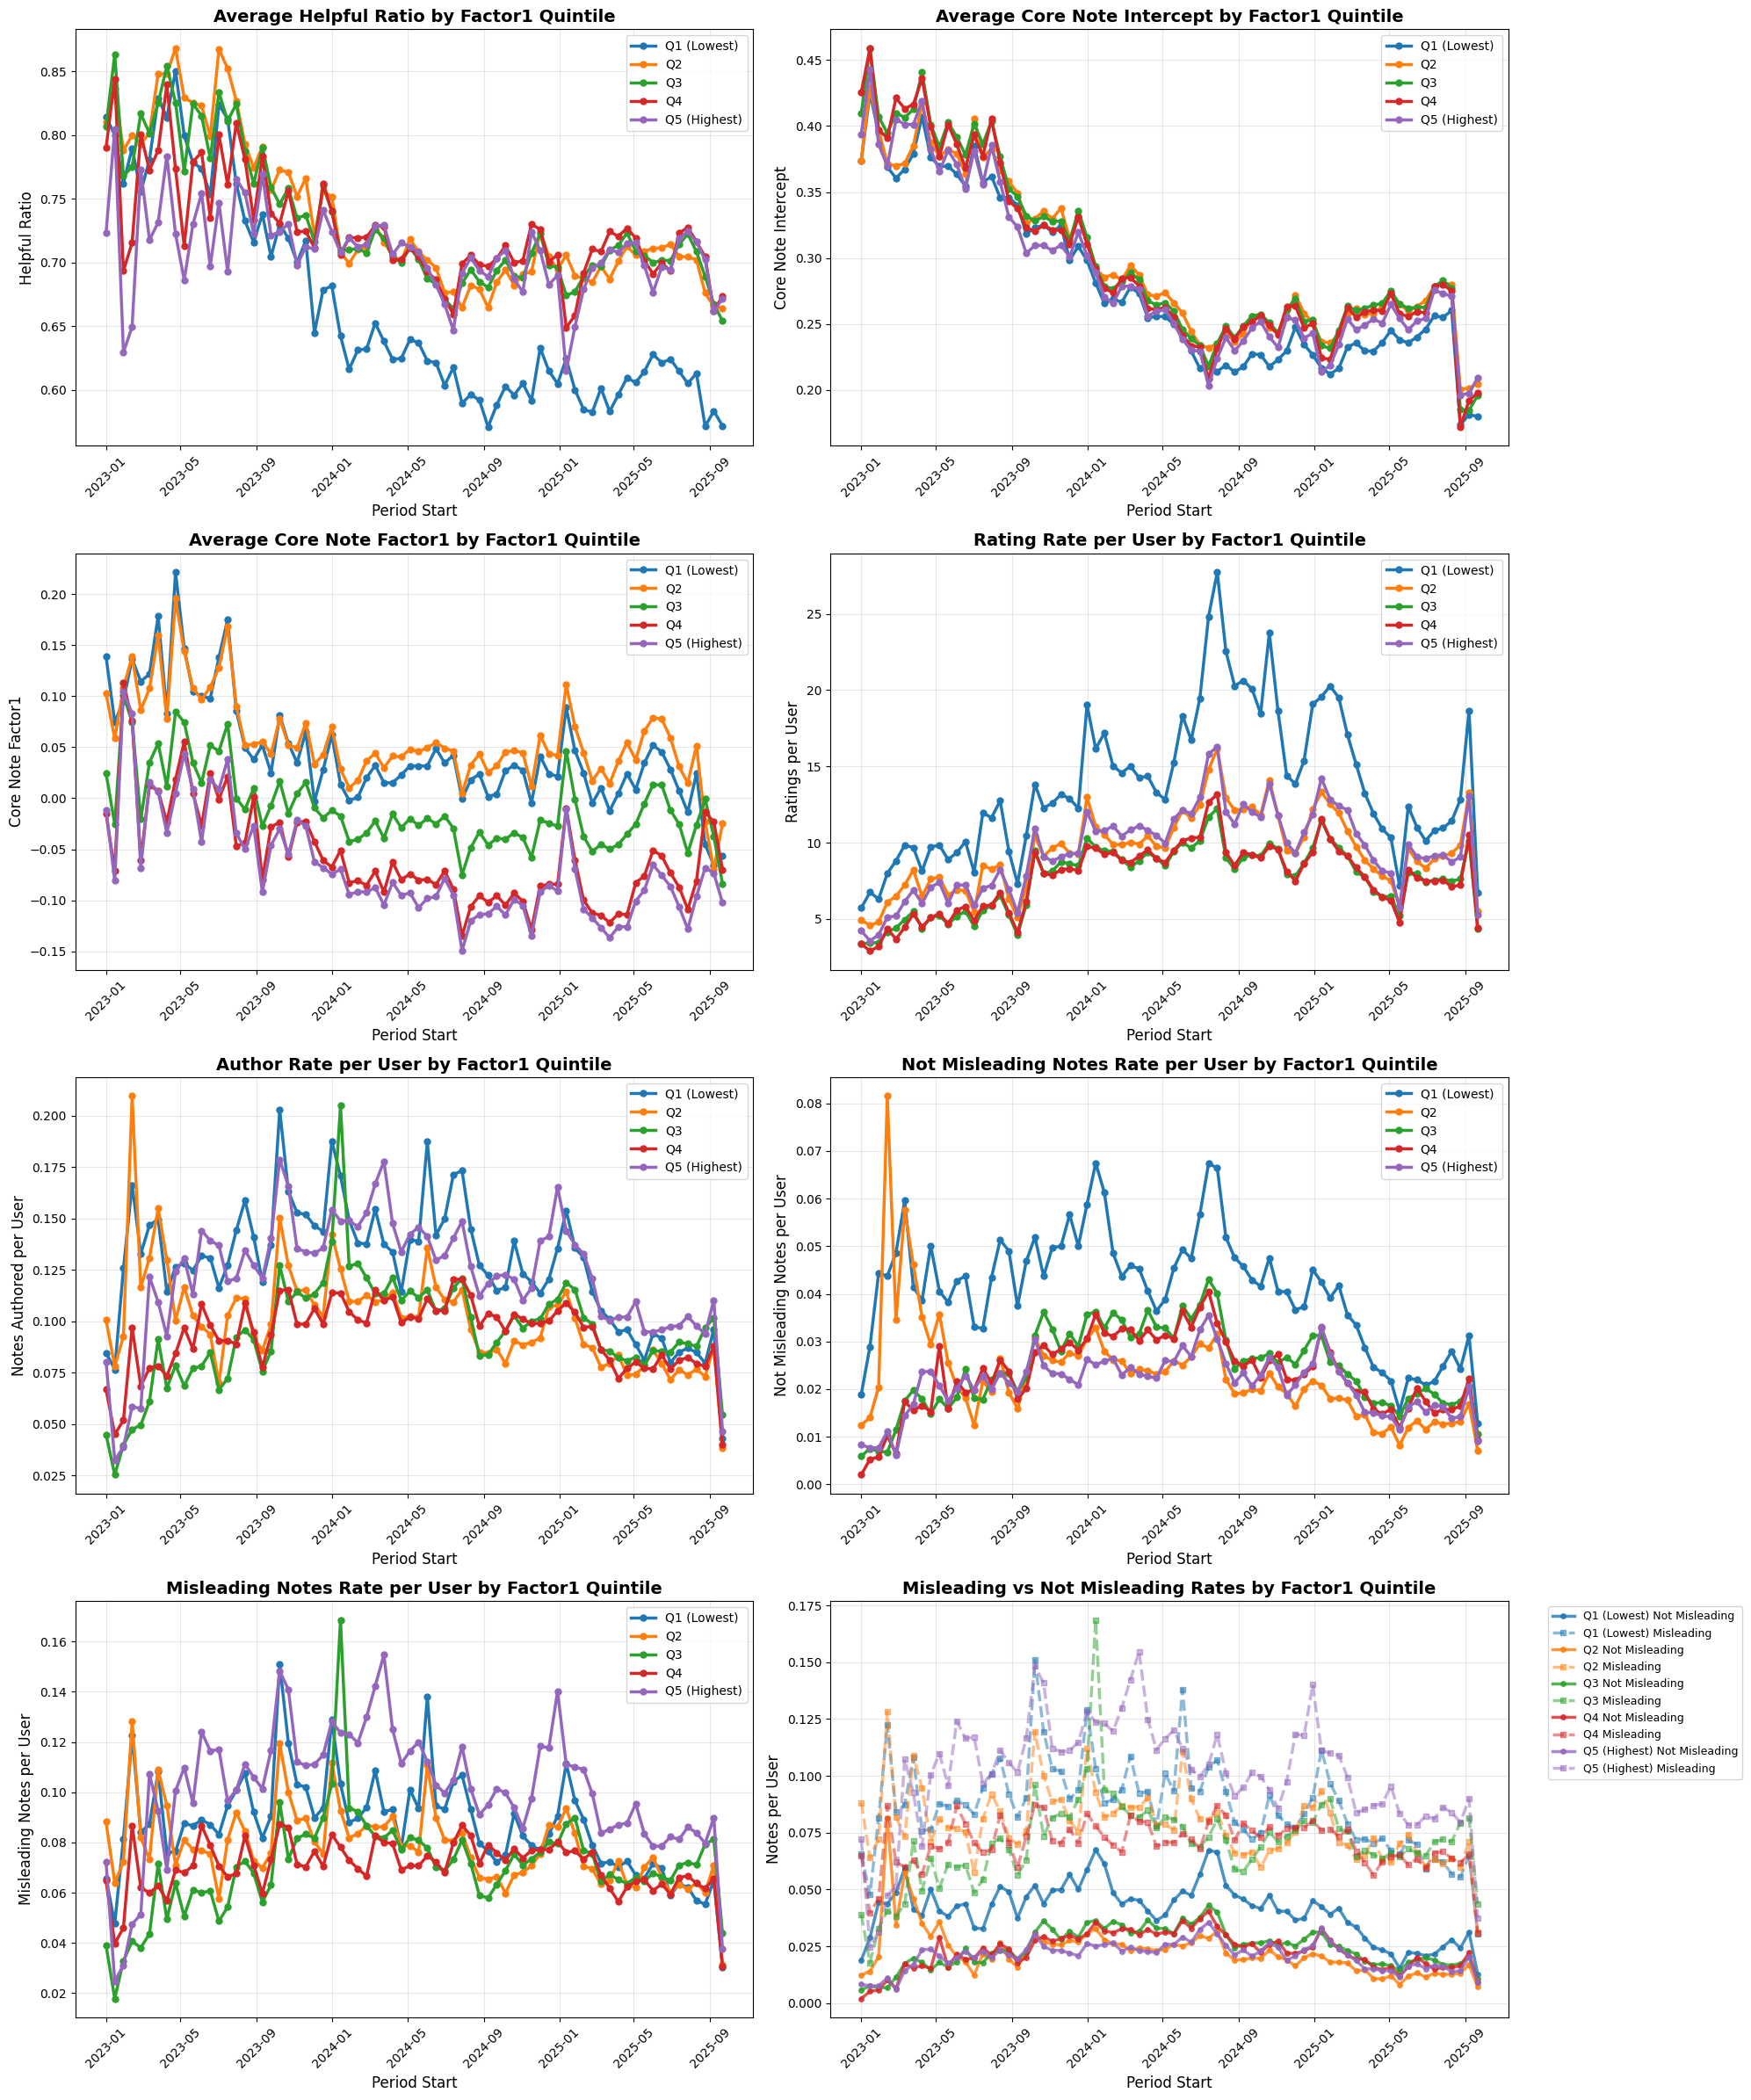

In [10]:
# Create comprehensive visualization with all requested metrics
fig, axes = plt.subplots(4, 2, figsize=(20, 24))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # More distinct colors
quintile_labels = ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']

# Graph 1: Average Helpful Ratio
ax1 = axes[0, 0]
for i, (quintile_name, dataset) in enumerate(quintile_comprehensive_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax1.plot(pandas_df['period_start'], pandas_df['avg_helpful_ratio'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax1.set_title('Average Helpful Ratio by Factor1 Quintile', fontsize=14, fontweight='bold')
ax1.set_xlabel('Period Start', fontsize=12)
ax1.set_ylabel('Helpful Ratio', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Graph 2: Average Core Note Intercept
ax2 = axes[0, 1]
for i, (quintile_name, dataset) in enumerate(quintile_comprehensive_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax2.plot(pandas_df['period_start'], pandas_df['avg_core_note_intercept'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax2.set_title('Average Core Note Intercept by Factor1 Quintile', fontsize=14, fontweight='bold')
ax2.set_xlabel('Period Start', fontsize=12)
ax2.set_ylabel('Core Note Intercept', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Graph 3: Average Core Note Factor1
ax3 = axes[1, 0]
for i, (quintile_name, dataset) in enumerate(quintile_comprehensive_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax3.plot(pandas_df['period_start'], pandas_df['avg_core_note_factor1'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax3.set_title('Average Core Note Factor1 by Factor1 Quintile', fontsize=14, fontweight='bold')
ax3.set_xlabel('Period Start', fontsize=12)
ax3.set_ylabel('Core Note Factor1', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Graph 4: Rating Rate per User
ax4 = axes[1, 1]
for i, (quintile_name, dataset) in enumerate(quintile_comprehensive_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df['rating_rate'] = pandas_df['total_ratings'] / pandas_df['user_count']
        
        ax4.plot(pandas_df['period_start'], pandas_df['rating_rate'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax4.set_title('Rating Rate per User by Factor1 Quintile', fontsize=14, fontweight='bold')
ax4.set_xlabel('Period Start', fontsize=12)
ax4.set_ylabel('Ratings per User', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Graph 5: Author Rate per User (Notes Authored)
ax5 = axes[2, 0]
for i, (quintile_name, dataset) in enumerate(quintile_comprehensive_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df['author_rate'] = pandas_df['total_notes_authored'] / pandas_df['user_count']
        
        ax5.plot(pandas_df['period_start'], pandas_df['author_rate'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax5.set_title('Author Rate per User by Factor1 Quintile', fontsize=14, fontweight='bold')
ax5.set_xlabel('Period Start', fontsize=12)
ax5.set_ylabel('Notes Authored per User', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# Graph 6: Not Misleading Rate per User
ax6 = axes[2, 1]
for i, (quintile_name, dataset) in enumerate(quintile_comprehensive_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df['not_misleading_rate'] = pandas_df['total_not_misleading'] / pandas_df['user_count']
        
        ax6.plot(pandas_df['period_start'], pandas_df['not_misleading_rate'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax6.set_title('Not Misleading Notes Rate per User by Factor1 Quintile', fontsize=14, fontweight='bold')
ax6.set_xlabel('Period Start', fontsize=12)
ax6.set_ylabel('Not Misleading Notes per User', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.tick_params(axis='x', rotation=45)

# Graph 7: Misleading Rate per User
ax7 = axes[3, 0]
for i, (quintile_name, dataset) in enumerate(quintile_comprehensive_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df['misleading_rate'] = pandas_df['total_misleading'] / pandas_df['user_count']
        
        ax7.plot(pandas_df['period_start'], pandas_df['misleading_rate'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax7.set_title('Misleading Notes Rate per User by Factor1 Quintile', fontsize=14, fontweight='bold')
ax7.set_xlabel('Period Start', fontsize=12)
ax7.set_ylabel('Misleading Notes per User', fontsize=12)
ax7.legend()
ax7.grid(True, alpha=0.3)
ax7.tick_params(axis='x', rotation=45)

# Graph 8: Combined Misleading vs Not Misleading Rates
ax8 = axes[3, 1]
for i, (quintile_name, dataset) in enumerate(quintile_comprehensive_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df['not_misleading_rate'] = pandas_df['total_not_misleading'] / pandas_df['user_count']
        pandas_df['misleading_rate'] = pandas_df['total_misleading'] / pandas_df['user_count']
        
        # Plot both lines for this quintile
        ax8.plot(pandas_df['period_start'], pandas_df['not_misleading_rate'], 
                color=colors[i], linewidth=2.5, marker='o', markersize=4, alpha=0.8,
                label=f'{quintile_labels[i]} Not Misleading')
        ax8.plot(pandas_df['period_start'], pandas_df['misleading_rate'], 
                color=colors[i], linewidth=2.5, marker='s', markersize=4, alpha=0.5, linestyle='--',
                label=f'{quintile_labels[i]} Misleading')

ax8.set_title('Misleading vs Not Misleading Rates by Factor1 Quintile', fontsize=14, fontweight='bold')
ax8.set_xlabel('Period Start', fontsize=12)
ax8.set_ylabel('Notes per User', fontsize=12)
ax8.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
ax8.grid(True, alpha=0.3)
ax8.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [11]:
# Print comprehensive summary statistics for quintile analysis
print("Comprehensive Summary Statistics by Factor1 Quintile")
print("=" * 100)

# Create a comprehensive summary table
summary_data = []

for quintile_name, dataset in quintile_comprehensive_datasets.items():
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        
        # Calculate all rates
        pandas_df['rating_rate'] = pandas_df['total_ratings'] / pandas_df['user_count']
        pandas_df['author_rate'] = pandas_df['total_notes_authored'] / pandas_df['user_count']
        pandas_df['not_misleading_rate'] = pandas_df['total_not_misleading'] / pandas_df['user_count']
        pandas_df['misleading_rate'] = pandas_df['total_misleading'] / pandas_df['user_count']
        
        # Get quintile info
        quintile_info = quintile_categories[quintile_name]
        factor1_range = f"{quintile_info['min_factor1']:.3f} to {quintile_info['max_factor1']:.3f}"
        
        summary_data.append({
            'Quintile': quintile_name.replace('_', ' ').title(),
            'Factor1_Range': factor1_range,
            'Participants': f"{quintile_info['count']:,}",
            'Avg_Helpful_Ratio': f"{pandas_df['avg_helpful_ratio'].mean():.3f}",
            'Avg_Core_Intercept': f"{pandas_df['avg_core_note_intercept'].mean():.3f}",
            'Avg_Core_Factor1': f"{pandas_df['avg_core_note_factor1'].mean():.3f}",
            'Avg_Rating_Rate': f"{pandas_df['rating_rate'].mean():.2f}",
            'Avg_Author_Rate': f"{pandas_df['author_rate'].mean():.2f}",
            'Avg_NotMisleading_Rate': f"{pandas_df['not_misleading_rate'].mean():.2f}",
            'Avg_Misleading_Rate': f"{pandas_df['misleading_rate'].mean():.2f}"
        })

# Create and display DataFrame
summary_df = pd.DataFrame(summary_data)

# Set pandas display options to show all data
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(summary_df.to_string(index=False))

# Reset display options
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print("\n" + "=" * 100)
print("Legend:")
print("- Helpful Ratio: Proportion of ratings marked as helpful")
print("- Core Intercept: Average quality score of notes rated")
print("- Core Factor1: Average factor1 score of notes rated")
print("- Rating Rate: Ratings given per user per 2-week period")
print("- Author Rate: Notes authored per user per 2-week period")
print("- Not Misleading Rate: Not misleading notes per user per 2-week period")
print("- Misleading Rate: Misleading notes per user per 2-week period")

Comprehensive Summary Statistics by Factor1 Quintile
  Quintile    Factor1_Range Participants Avg_Helpful_Ratio Avg_Core_Intercept Avg_Core_Factor1 Avg_Rating_Rate Avg_Author_Rate Avg_NotMisleading_Rate Avg_Misleading_Rate
Quintile 1 -1.515 to -0.601       39,482             0.665              0.280            0.045           13.76            0.13                   0.04                0.09
Quintile 2 -0.601 to -0.410       39,482             0.736              0.298            0.057            9.47            0.10                   0.02                0.08
Quintile 3 -0.410 to -0.231       39,482             0.732              0.301           -0.010            7.66            0.09                   0.02                0.07
Quintile 4 -0.231 to -0.064       39,482             0.725              0.297           -0.057            7.67            0.09                   0.02                0.07
Quintile 5  -0.064 to 0.833       39,483             0.708              0.288           -0.068   

In [15]:
# Create comprehensive datasets for quintile analysis with note status metrics
quintile_note_status_datasets = {}

for quintile_name, quintile_info in quintile_categories.items():
    participant_ids = quintile_info['participants']
    
    if len(participant_ids) > 0:
        # Filter main dataset where userId is in the participant_ids list
        filtered_df = main_df.filter(pl.col("userId").is_in(participant_ids))
        
        # Group by period_start and calculate note status aggregates
        agg_df = filtered_df.group_by("period_start").agg([
            # Note status counts
            pl.col("currently_helpful_count").sum().alias("total_currently_helpful"),
            pl.col("currently_not_helpful_count").sum().alias("total_currently_not_helpful"),
            pl.col("needs_more_ratings_count").sum().alias("total_needs_more_ratings"),
            
            # User count for calculations
            pl.count().alias("user_count")
        ]).sort("period_start")
        
        quintile_note_status_datasets[quintile_name] = agg_df
        print(f"{quintile_name}: {len(filtered_df)} records, {len(agg_df)} time periods")

print("\nQuintile note status datasets created successfully!")

C:\Users\wongb\AppData\Local\Temp\ipykernel_29220\3858894939.py:19: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("user_count")


quintile_1: 1497534 records, 72 time periods
quintile_2: 1201071 records, 72 time periods
quintile_2: 1201071 records, 72 time periods
quintile_3: 1040661 records, 72 time periods
quintile_3: 1040661 records, 72 time periods
quintile_4: 1035568 records, 72 time periods
quintile_4: 1035568 records, 72 time periods
quintile_5: 1144785 records, 72 time periods

Quintile note status datasets created successfully!
quintile_5: 1144785 records, 72 time periods

Quintile note status datasets created successfully!


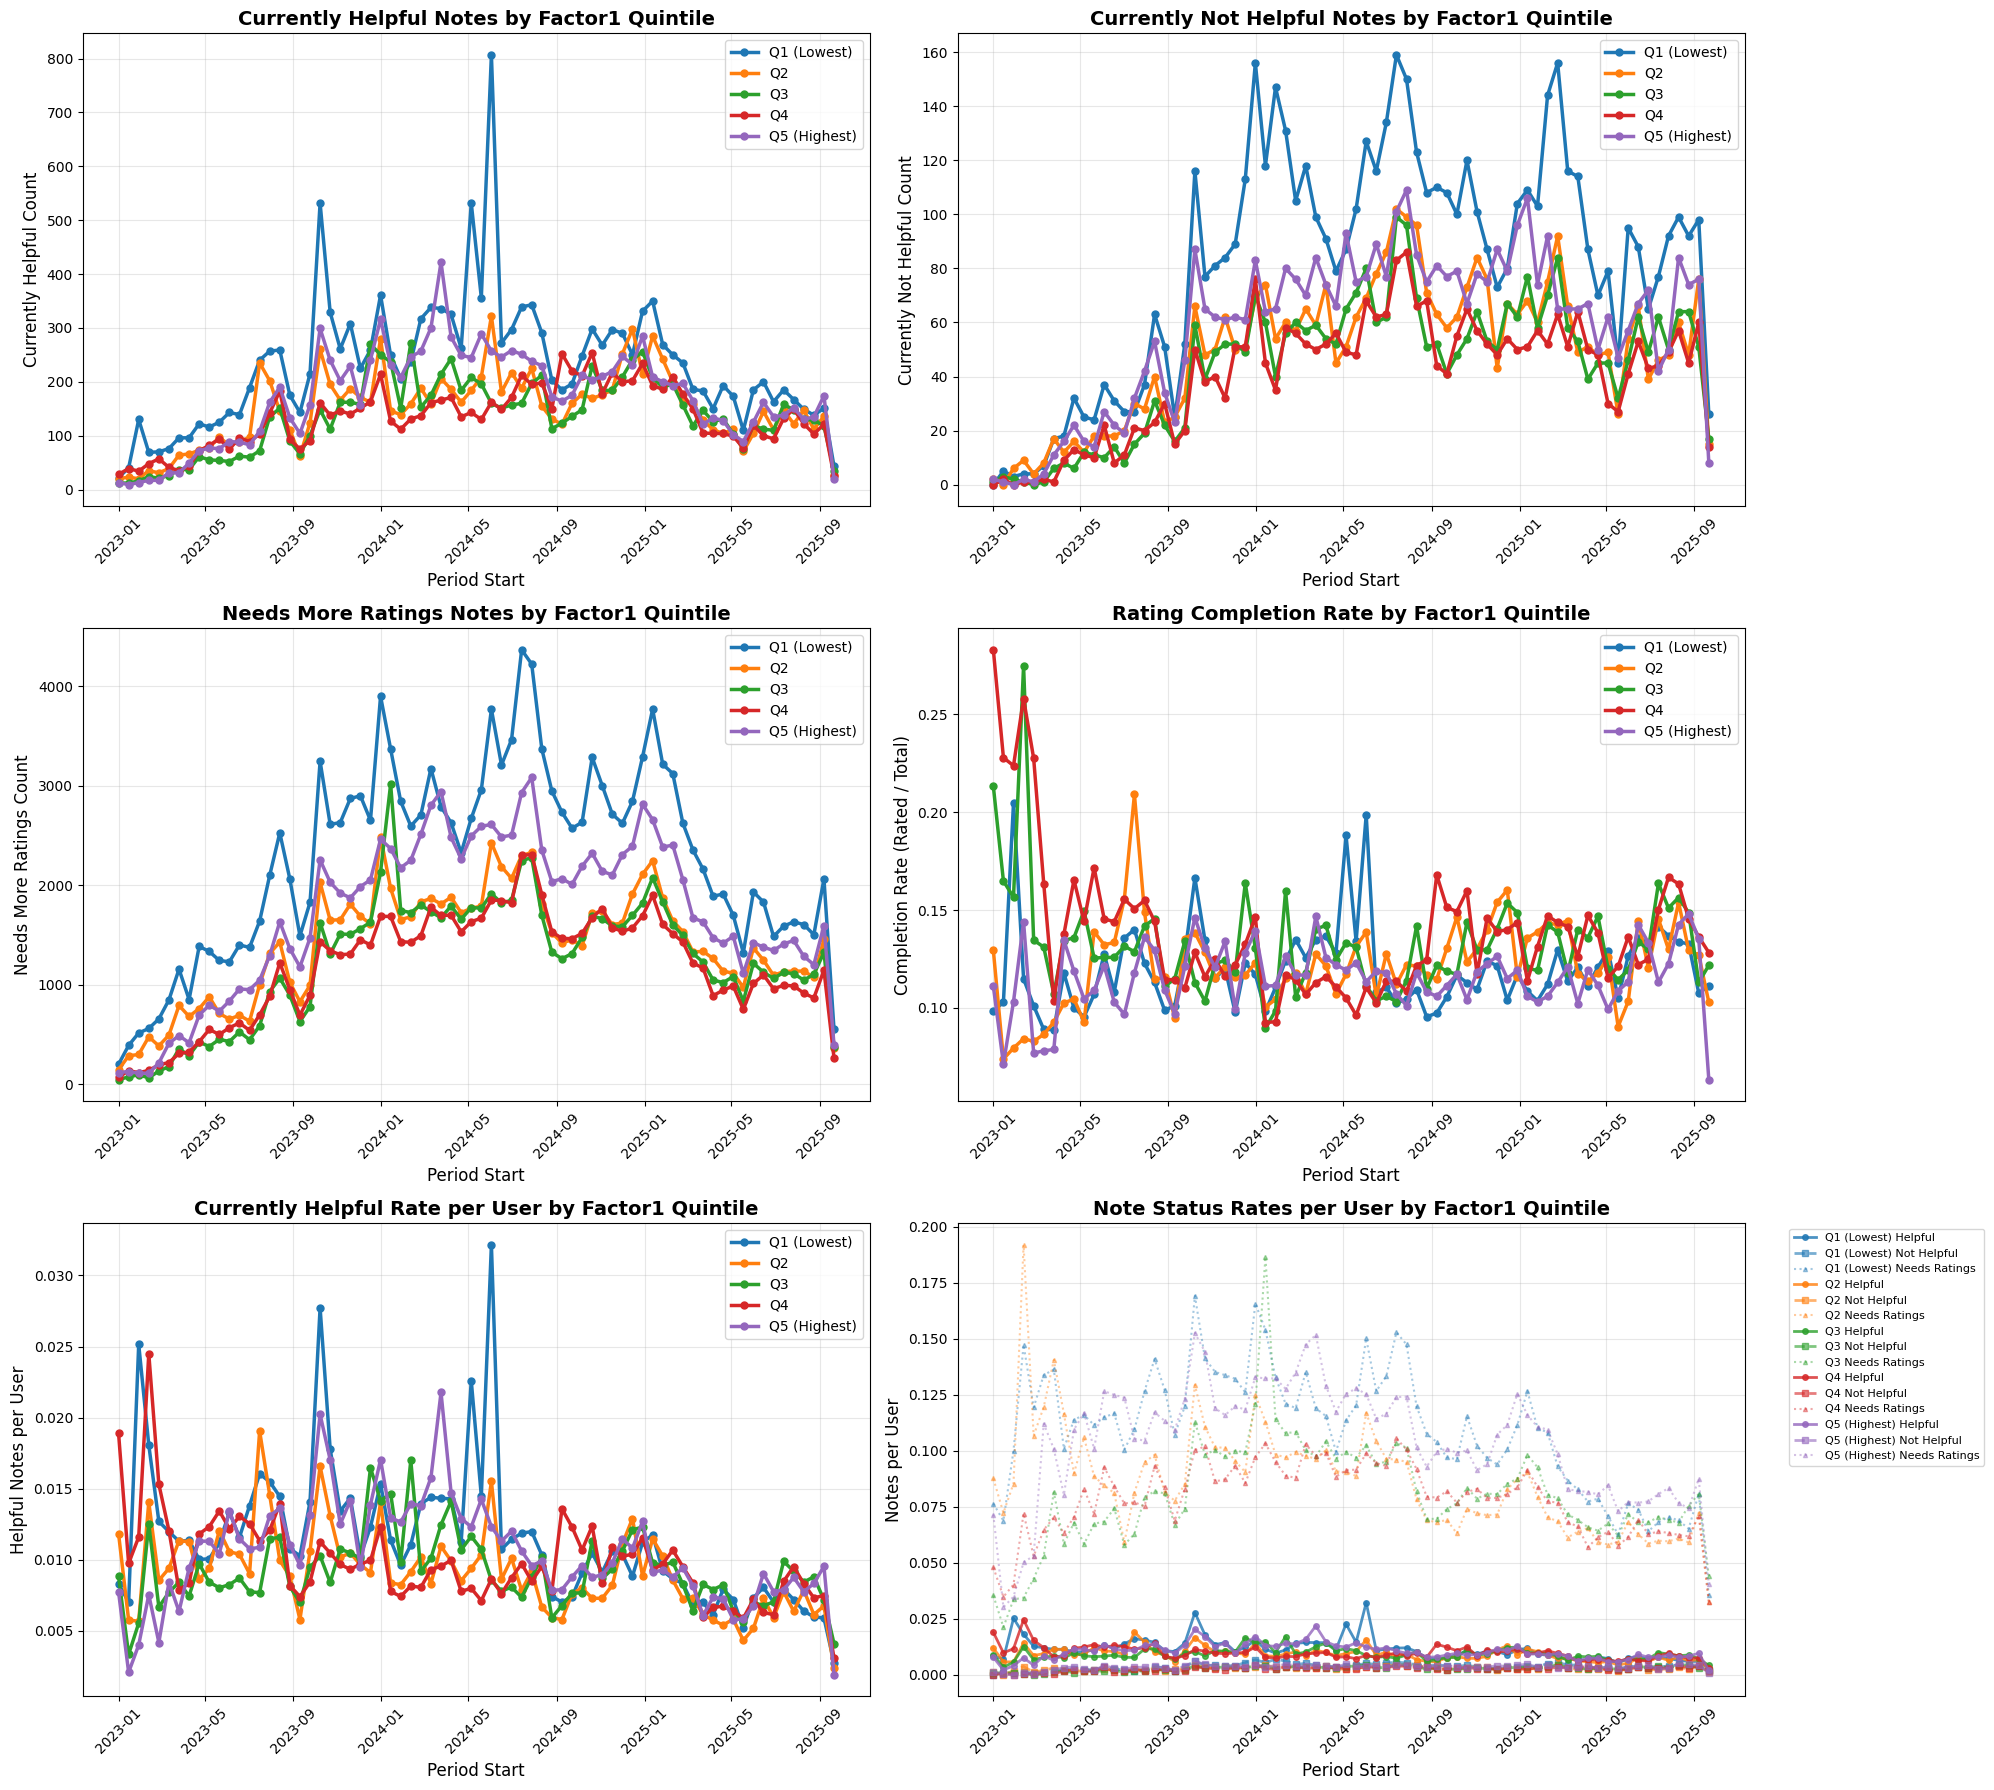

In [ ]:
import matplotlib as plt

# Create visualization for note status metrics by quintiles
fig, axes = plt.subplots(3, 2, figsize=(20, 18))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
quintile_labels = ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']

# Graph 1: Currently Helpful Count
ax1 = axes[0, 0]
for i, (quintile_name, dataset) in enumerate(quintile_note_status_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax1.plot(pandas_df['period_start'], pandas_df['total_currently_helpful'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax1.set_title('Currently Helpful Notes by Factor1 Quintile', fontsize=14, fontweight='bold')
ax1.set_xlabel('Period Start', fontsize=12)
ax1.set_ylabel('Currently Helpful Count', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Graph 2: Currently Not Helpful Count
ax2 = axes[0, 1]
for i, (quintile_name, dataset) in enumerate(quintile_note_status_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax2.plot(pandas_df['period_start'], pandas_df['total_currently_not_helpful'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax2.set_title('Currently Not Helpful Notes by Factor1 Quintile', fontsize=14, fontweight='bold')
ax2.set_xlabel('Period Start', fontsize=12)
ax2.set_ylabel('Currently Not Helpful Count', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Graph 3: Needs More Ratings Count
ax3 = axes[1, 0]
for i, (quintile_name, dataset) in enumerate(quintile_note_status_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax3.plot(pandas_df['period_start'], pandas_df['total_needs_more_ratings'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax3.set_title('Needs More Ratings Notes by Factor1 Quintile', fontsize=14, fontweight='bold')
ax3.set_xlabel('Period Start', fontsize=12)
ax3.set_ylabel('Needs More Ratings Count', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Graph 4: Rating Completion Rate (Currently Rated / Total Notes)
ax4 = axes[1, 1]
for i, (quintile_name, dataset) in enumerate(quintile_note_status_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        # Calculate rating completion rate
        pandas_df['total_currently_rated'] = pandas_df['total_currently_helpful'] + pandas_df['total_currently_not_helpful']
        pandas_df['total_notes'] = pandas_df['total_currently_rated'] + pandas_df['total_needs_more_ratings']
        pandas_df['rating_completion_rate'] = pandas_df['total_currently_rated'] / pandas_df['total_notes']
        pandas_df['rating_completion_rate'] = pandas_df['rating_completion_rate'].fillna(0)  # Handle division by zero
        
        ax4.plot(pandas_df['period_start'], pandas_df['rating_completion_rate'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax4.set_title('Rating Completion Rate by Factor1 Quintile', fontsize=14, fontweight='bold')
ax4.set_xlabel('Period Start', fontsize=12)
ax4.set_ylabel('Completion Rate (Rated / Total)', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Graph 5: Per User Note Status Rates - Helpful
ax5 = axes[2, 0]
for i, (quintile_name, dataset) in enumerate(quintile_note_status_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df['helpful_rate_per_user'] = pandas_df['total_currently_helpful'] / pandas_df['user_count']
        
        ax5.plot(pandas_df['period_start'], pandas_df['helpful_rate_per_user'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax5.set_title('Currently Helpful Rate per User by Factor1 Quintile', fontsize=14, fontweight='bold')
ax5.set_xlabel('Period Start', fontsize=12)
ax5.set_ylabel('Helpful Notes per User', fontsize=12)
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# Graph 6: Combined Per User Rates
ax6 = axes[2, 1]
for i, (quintile_name, dataset) in enumerate(quintile_note_status_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        pandas_df['helpful_rate_per_user'] = pandas_df['total_currently_helpful'] / pandas_df['user_count']
        pandas_df['not_helpful_rate_per_user'] = pandas_df['total_currently_not_helpful'] / pandas_df['user_count']
        pandas_df['needs_ratings_rate_per_user'] = pandas_df['total_needs_more_ratings'] / pandas_df['user_count']
        
        # Plot all three rates for this quintile
        ax6.plot(pandas_df['period_start'], pandas_df['helpful_rate_per_user'], 
                color=colors[i], linewidth=2, marker='o', markersize=4, alpha=0.8,
                label=f'{quintile_labels[i]} Helpful')
        ax6.plot(pandas_df['period_start'], pandas_df['not_helpful_rate_per_user'], 
                color=colors[i], linewidth=2, marker='s', markersize=4, alpha=0.6, linestyle='--',
                label=f'{quintile_labels[i]} Not Helpful')
        ax6.plot(pandas_df['period_start'], pandas_df['needs_ratings_rate_per_user'], 
                color=colors[i], linewidth=1.5, marker='^', markersize=3, alpha=0.4, linestyle=':',
                label=f'{quintile_labels[i]} Needs Ratings')

ax6.set_title('Note Status Rates per User by Factor1 Quintile', fontsize=14, fontweight='bold')
ax6.set_xlabel('Period Start', fontsize=12)
ax6.set_ylabel('Notes per User', fontsize=12)
ax6.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
ax6.grid(True, alpha=0.3)
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [17]:
# Print comprehensive summary statistics for note status by quintile
print("Note Status Summary Statistics by Factor1 Quintile")
print("=" * 120)

# Create a comprehensive summary table
summary_data = []

for quintile_name, dataset in quintile_note_status_datasets.items():
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        
        # Calculate rates and ratios
        pandas_df['total_currently_rated'] = pandas_df['total_currently_helpful'] + pandas_df['total_currently_not_helpful']
        pandas_df['total_notes'] = pandas_df['total_currently_rated'] + pandas_df['total_needs_more_ratings']
        pandas_df['rating_completion_rate'] = pandas_df['total_currently_rated'] / pandas_df['total_notes']
        pandas_df['helpful_not_helpful_ratio'] = pandas_df['total_currently_helpful'] / pandas_df['total_currently_not_helpful']
        pandas_df['helpful_rate_per_user'] = pandas_df['total_currently_helpful'] / pandas_df['user_count']
        pandas_df['not_helpful_rate_per_user'] = pandas_df['total_currently_not_helpful'] / pandas_df['user_count']
        pandas_df['needs_ratings_rate_per_user'] = pandas_df['total_needs_more_ratings'] / pandas_df['user_count']
        
        # Get quintile info
        quintile_info = quintile_categories[quintile_name]
        factor1_range = f"{quintile_info['min_factor1']:.3f} to {quintile_info['max_factor1']:.3f}"
        
        # Calculate totals and averages
        total_helpful = pandas_df['total_currently_helpful'].sum()
        total_not_helpful = pandas_df['total_currently_not_helpful'].sum()
        total_needs_ratings = pandas_df['total_needs_more_ratings'].sum()
        avg_completion_rate = pandas_df['rating_completion_rate'].mean()
        avg_helpful_ratio = pandas_df['helpful_not_helpful_ratio'].replace([float('inf'), -float('inf')], float('nan')).mean()
        
        summary_data.append({
            'Quintile': quintile_name.replace('_', ' ').title(),
            'Factor1_Range': factor1_range,
            'Total_Helpful': f"{total_helpful:,}",
            'Total_Not_Helpful': f"{total_not_helpful:,}",
            'Total_Needs_Ratings': f"{total_needs_ratings:,}",
            'Avg_Completion_Rate': f"{avg_completion_rate:.3f}",
            'Avg_Helpful_Ratio': f"{avg_helpful_ratio:.2f}" if not pd.isna(avg_helpful_ratio) else "N/A",
            'Helpful_Rate_Per_User': f"{pandas_df['helpful_rate_per_user'].mean():.2f}",
            'NotHelpful_Rate_Per_User': f"{pandas_df['not_helpful_rate_per_user'].mean():.2f}",
            'NeedsRatings_Rate_Per_User': f"{pandas_df['needs_ratings_rate_per_user'].mean():.2f}"
        })

# Create and display DataFrame
summary_df = pd.DataFrame(summary_data)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(summary_df.to_string(index=False))

# Reset display options
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print("\n" + "=" * 120)
print("Legend:")
print("- Completion Rate: (Currently Helpful + Not Helpful) / Total Notes")
print("- Helpful Ratio: Currently Helpful / Currently Not Helpful")
print("- Rates Per User: Average count per user per 2-week period")
print("- Higher completion rates indicate notes get rated faster")
print("- Higher helpful ratios indicate better quality note authoring")

Note Status Summary Statistics by Factor1 Quintile
  Quintile    Factor1_Range Total_Helpful Total_Not_Helpful Total_Needs_Ratings Avg_Completion_Rate Avg_Helpful_Ratio Helpful_Rate_Per_User NotHelpful_Rate_Per_User NeedsRatings_Rate_Per_User
Quintile 1 -1.515 to -0.601      16,550.0           5,837.0           163,008.0               0.120              4.32                  0.01                     0.00                       0.11
Quintile 2 -0.601 to -0.410      10,650.0           3,561.0            99,548.0               0.122              3.49                  0.01                     0.00                       0.09
Quintile 3 -0.410 to -0.231       9,809.0           3,185.0            89,090.0               0.132              4.30                  0.01                     0.00                       0.08
Quintile 4 -0.231 to -0.064       9,620.0           2,920.0            84,597.0               0.139              6.03                  0.01                     0.00                 

In [ ]:
# Load the complete dataset with authored scores
authored_scores_path = r"C:\Users\wongb\twitter-community-notes-time-series\twitter-community-notes-user-time-series\aggregator\data\user_period_master_complete_with_authored_scores.parquet"
authored_df = pl.read_parquet(authored_scores_path)

print(f"Authored scores dataset shape: {authored_df.shape}")
print(f"Columns: {authored_df.columns}")

In [ ]:
# Create quintile datasets for authored note scores analysis
quintile_authored_datasets = {}

for quintile_name, quintile_info in quintile_categories.items():
    participant_ids = quintile_info['participants']
    
    if len(participant_ids) > 0:
        # Filter dataset where userId is in the participant_ids list
        filtered_df = authored_df.filter(pl.col("userId").is_in(participant_ids))
        
        # Group by period_start and calculate authored note score aggregates
        agg_df = filtered_df.group_by("period_start").agg([
            # Authored note score metrics
            pl.col("avg_authored_note_intercept").mean().alias("avg_authored_note_intercept"),
            pl.col("avg_authored_note_factor1").mean().alias("avg_authored_note_factor1"),
            pl.col("authored_notes_with_intercept").sum().alias("total_authored_with_intercept"),
            pl.col("authored_notes_with_factor1").sum().alias("total_authored_with_factor1"),
            
            # User count for calculations
            pl.count().alias("user_count")
        ]).sort("period_start")
        
        quintile_authored_datasets[quintile_name] = agg_df
        print(f"{quintile_name}: {len(filtered_df)} records, {len(agg_df)} time periods")

print("\nQuintile authored scores datasets created successfully!")

In [ ]:
# Create visualization for authored note scores by quintiles
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
quintile_labels = ['Q1 (Lowest)', 'Q2', 'Q3', 'Q4', 'Q5 (Highest)']

# Graph 1: Average Authored Note Intercept
ax1 = axes[0, 0]
for i, (quintile_name, dataset) in enumerate(quintile_authored_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        # Filter out null values for cleaner plotting
        pandas_df_clean = pandas_df.dropna(subset=['avg_authored_note_intercept'])
        
        if len(pandas_df_clean) > 0:
            ax1.plot(pandas_df_clean['period_start'], pandas_df_clean['avg_authored_note_intercept'], 
                    color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax1.set_title('Average Authored Note Intercept by Factor1 Quintile', fontsize=14, fontweight='bold')
ax1.set_xlabel('Period Start', fontsize=12)
ax1.set_ylabel('Average Authored Note Intercept', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Graph 2: Average Authored Note Factor1
ax2 = axes[0, 1]
for i, (quintile_name, dataset) in enumerate(quintile_authored_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        # Filter out null values for cleaner plotting
        pandas_df_clean = pandas_df.dropna(subset=['avg_authored_note_factor1'])
        
        if len(pandas_df_clean) > 0:
            ax2.plot(pandas_df_clean['period_start'], pandas_df_clean['avg_authored_note_factor1'], 
                    color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax2.set_title('Average Authored Note Factor1 by Factor1 Quintile', fontsize=14, fontweight='bold')
ax2.set_xlabel('Period Start', fontsize=12)
ax2.set_ylabel('Average Authored Note Factor1', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Graph 3: Total Authored Notes with Intercept Scores
ax3 = axes[1, 0]
for i, (quintile_name, dataset) in enumerate(quintile_authored_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax3.plot(pandas_df['period_start'], pandas_df['total_authored_with_intercept'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax3.set_title('Total Authored Notes with Intercept Scores by Factor1 Quintile', fontsize=14, fontweight='bold')
ax3.set_xlabel('Period Start', fontsize=12)
ax3.set_ylabel('Authored Notes with Intercept', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Graph 4: Total Authored Notes with Factor1 Scores
ax4 = axes[1, 1]
for i, (quintile_name, dataset) in enumerate(quintile_authored_datasets.items()):
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        pandas_df['period_start'] = pd.to_datetime(pandas_df['period_start'])
        
        ax4.plot(pandas_df['period_start'], pandas_df['total_authored_with_factor1'], 
                color=colors[i], label=quintile_labels[i], linewidth=2.5, marker='o', markersize=5)

ax4.set_title('Total Authored Notes with Factor1 Scores by Factor1 Quintile', fontsize=14, fontweight='bold')
ax4.set_xlabel('Period Start', fontsize=12)
ax4.set_ylabel('Authored Notes with Factor1', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Print summary statistics for authored note scores by quintile
print("Authored Note Scores Summary Statistics by Factor1 Quintile")
print("=" * 100)

# Create a summary table
summary_data = []

for quintile_name, dataset in quintile_authored_datasets.items():
    if len(dataset) > 0:
        pandas_df = dataset.to_pandas()
        
        # Get quintile info
        quintile_info = quintile_categories[quintile_name]
        factor1_range = f"{quintile_info['min_factor1']:.3f} to {quintile_info['max_factor1']:.3f}"
        
        # Calculate statistics (ignoring null values)
        avg_intercept = pandas_df['avg_authored_note_intercept'].dropna().mean()
        avg_factor1 = pandas_df['avg_authored_note_factor1'].dropna().mean()
        total_with_intercept = pandas_df['total_authored_with_intercept'].sum()
        total_with_factor1 = pandas_df['total_authored_with_factor1'].sum()
        
        # Calculate per user rates
        avg_intercept_per_user = total_with_intercept / pandas_df['user_count'].sum() if pandas_df['user_count'].sum() > 0 else 0
        avg_factor1_per_user = total_with_factor1 / pandas_df['user_count'].sum() if pandas_df['user_count'].sum() > 0 else 0
        
        summary_data.append({
            'Quintile': quintile_name.replace('_', ' ').title(),
            'Factor1_Range': factor1_range,
            'Participants': f"{quintile_info['count']:,}",
            'Avg_Authored_Intercept': f"{avg_intercept:.3f}" if not pd.isna(avg_intercept) else "N/A",
            'Avg_Authored_Factor1': f"{avg_factor1:.3f}" if not pd.isna(avg_factor1) else "N/A",
            'Total_Notes_w_Intercept': f"{total_with_intercept:,}",
            'Total_Notes_w_Factor1': f"{total_with_factor1:,}",
            'Intercept_Notes_Per_User': f"{avg_intercept_per_user:.2f}",
            'Factor1_Notes_Per_User': f"{avg_factor1_per_user:.2f}"
        })

# Create and display DataFrame
summary_df = pd.DataFrame(summary_data)

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print(summary_df.to_string(index=False))

# Reset display options
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

print("\n" + "=" * 100)
print("Legend:")
print("- Avg Authored Intercept/Factor1: Quality of notes written by users in each quintile")
print("- Total Notes w/ Scores: Number of authored notes that received quality scores")
print("- Notes Per User: Average authored notes with scores per user across all periods")
print("- Higher intercept = better quality authored notes")
print("- Factor1 shows ideological bias of authored content")